In [1]:
using DelimitedFiles
using PyPlot
using LinearAlgebra
using IJulia
using JuMP
using Ipopt
using Statistics

In [2]:
function rowsum(A) #Returns a column vector containing the row sums of square matrix A
    m = size(A,1)
    rowsum = zeros(n,1)
    for i in 1:m
        rowsum[i] = sum(A[i,:])
    end
    return rowsum
end

function colsum(A) #Returns a column vector containing the column sums of square matrix A
    n = size(A,2)
    colsum = zeros(n,1)
    for i in 1:n
        colsum[i] = sum(A[:,i])
    end
    return colsum
end

colsum (generic function with 1 method)

In [3]:
#Control of opinion dynamics control in social network: OSA, DeGroot, Jacobi approach

####################################

#COD = controlled opinion dynamics, J = Jacobi information exchange; targets for players are specified
function COD_OSA_J_targets_DeGroot(x_init,player_targets,γ,K_f,A,B,N_a,N_p,u_min,u_max)
    #Initialize arrays
    x_os = zeros(N_a,K_f + 1)  #Column j: opinions of N_a agents at instant j, Row i: time evolution of agent i's opinion
    u_os = zeros(N_p,K_f)      #Column j: controls of N_p players at instant j, Row i: time evolution of player i's controls
    x_os[:,1] = x_init         #Initial states (opinions) of each agent
    temp = zeros(N_a,K_f+1)        #Temporary vector to projection
    temp[:,1] = x_init
    flag = [0 0];
    for k in 1:K_f #Time loop
            for p in 1:N_p #player loop
            
                #Name the model, define the solver and set its attributes
                S = "$p"
                S = Model(Ipopt.Optimizer)
                set_optimizer_attributes(S, "print_level" => 0 )
            
                #Define the optimization variables
                @variable(S, v) #v is the scalar value of the control for player p
                @variable(S, xn[1:N_a,1:1]) #xn is the new state of agent influenced by p
            
                #Define the control constraints
                @constraint(S, u_min <= v <= u_max)
            
                #Define the dynamical constraint
                @constraint(S, xn .== A*x_os[:,k] + B[:,p]*v)
                @constraint(S, 0 .<= xn .<= 1 ) #Restrição nas opiniões
                #for i in 1:N_a
                #    @constraint(S, 0 <= xn[i] <=1)
                #end
                #Define the objective function for each agent
                @objective(S, Min, sum((xn - player_targets[:,p]).^2) + γ[p]*v*v)
            
                optimize!(S)
            
                #Retrieve optimal values for k-th iteration (instant)
                u_os[p,k] = JuMP.value.(S[:v])
            end
        temp[:,k+1] = A*x_os[:,k] + B*u_os[:,k]
        
        for i in 1:N_a
            if temp[i,k+1] > 1
                x_os[i,k+1] = 1
                flag = [flag[1] 1];
            elseif temp[i,k+1] < 0
                x_os[i,k+1] = 0
                flag = [1 flag[2]];
            else
                x_os[i,k+1] = temp[i,k+1]
            end
        end
        
    end
    return x_os, u_os, temp, flag
end

COD_OSA_J_targets_DeGroot (generic function with 1 method)

# Testes

### Run all codes cell first (go bellow)

In [13]:
## These are the choises for (N)
# 1 - Projection not required and orthogonal, Eig < 1
# 2 - Projection not required and Non-Orthogonal, Eig < 1
# 3 - Projection required and Orthogonal, Eig < 1
# 4 - Projection required and Non-Orthogonal, Eig < 1
# 5 - Eig > 1, oscillatory
##

N = 4
K_f = 50
x_os, u_os, temp, flag, x_os_eq, temp_eq, eig, control, target, A, B, Acl = case(N, K_f);
println("The espectral radius ρ is: ", maximum(abs.(eig)))

The espectral radius ρ is: 0.35278740960615473


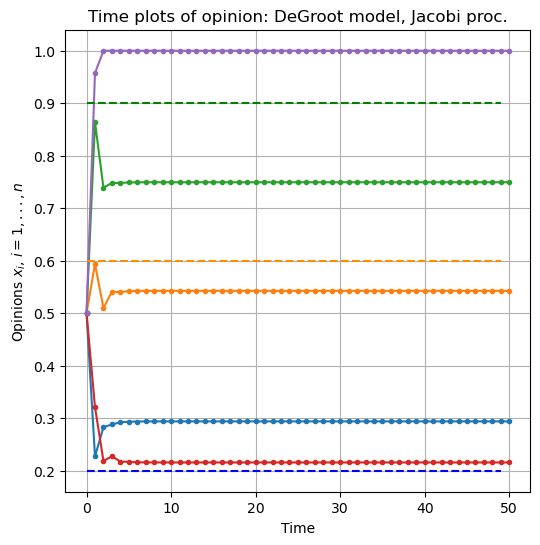

PyObject Text(0.5, 1.0, 'Time plots of opinion: DeGroot model, Jacobi proc.')

In [14]:
## Plot cases
# 1 - Optimization with projection
# 2 - Closed Form with projection
# 3 - Optimization without projection
# 4 - Closed Form without projectin
# 5 - Optimization and closed form with projection
# 6 - Optimization and closed form without projection

figure(figsize=(6,6))
grid()

P = 1
    if P == 1
        for i in 1:size(x_os,1)
            plot(x_os[i,:],".-")
        end
    elseif P == 2
        for i in 1:size(x_os_eq,1)
            plot(x_os_eq[i,:],".-")
        end
    elseif P == 3
        for i in 1:size(temp,1)
            plot(temp[i,:],"*-")
        end
    elseif P == 4
        for i in 1:size(temp_eq,1)
            plot(temp_eq[i,:],"*-")
        end
    elseif P == 4
        for i in 1:size(x_os,1)
            plot(x_os[i,:],".-")
        end
        for i in 1:size(temp,1)
            plot(temp[i,:],"*-")
        end
    elseif P == 4
        for i in 1:size(x_os_eq,1)
            plot(x_os_eq[i,:],".-")
        end
        for i in 1:size(temp_eq,1)
            plot(temp_eq[i,:],"*-")
        end
    end

if N==2 || N==1 || N==4
    plot(target[1].*ones(K_f,1),"--",color = "blue");
    plot(target[2].*ones(K_f,1),"--",color = "darkorange");
    plot(target[3].*ones(K_f,1),"--",color = "green"); 
end
    
xlabel("Time")
ylabel("Opinions \$x_i\$, \$i=1,...,n\$")
#legend([L"x_1",L"x_2", L"x_3", L"x_4", L"x_5", L"temp_1",L"temp_2",L"temp_3",L"temp_4",L"temp_5"],loc="right")
title("Time plots of opinion: DeGroot model, Jacobi proc.")

# All Codes

In [4]:
function case(T, time)
    if T==1
        #Dynamics
        A = [0.1 0.4 0.2 0.1 0.2; 0.5 0.1 0.1 0.1 0.2; 0.3 0.1 0.4 0.1 0.1; 0.1 0.1 0.3 0.4 0.1; 0.2 0.05 0.1 0.45 0.2];
        B = [0.5 0 0; 0 0.5 0; 0 0 0.5; 0 0 0; 0 0 0];
        x1_hat_1 = 0.2
        x2_hat_1 = 0.6
        x3_hat_1 = 0.9
        target_vec = [x1_hat_1;x2_hat_1;x3_hat_1]
        targets = [x1_hat_1      0        0; 
                       0        x2_hat_1    0; 
                       0           0       x3_hat_1;
                       0           0        0;
                       0           0        0];
        γ = [0.03; 0.03; 0.03];
        N_a = size(A,2);
        N_p = size(B,2)
        x_init = 0.5*ones(N_a);
    elseif T == 2
        #Dynamics
        A = [0.1 0.4 0.2 0.1 0.2; 0.5 0.1 0.1 0.1 0.2; 0.3 0.1 0.4 0.1 0.1; 0.1 0.1 0.3 0.4 0.1; 0.2 0.05 0.1 0.45 0.2];
        B = [0.5 0 0; 0 0.5 0; 0 0 0.5; 0.5 0.5 0; 0 0.5 0.5];
        x1_hat_2 = 0.2
        x2_hat_2 = 0.6
        x3_hat_2 = 0.9   
        target_vec = [x1_hat_2;x2_hat_2;x3_hat_2]
        targets = [x1_hat_2    0        0;
                     0      x2_hat_2    0; 
                     0       0       x3_hat_2;
                 x1_hat_2   x2_hat_2    0;
                     0      x2_hat_2   x3_hat_2] 
        γ = [0.03; 0.03; 0.03];
        N_a = size(A,2);
        N_p = size(B,2)
        x_init = 0.5*ones(N_a);
    elseif T == 3 
        #Dynamics
        A_t = [80 55 30 75 0 0 0 0 0 0;
            55  54 63 0 64 0 0 0 0 0 ;
            60 40 65 74 67 0 0 0 0 0 ;
            75 0 55 25 85 34 12 0 0 0 ;
            0 64 38 85 85 0 0 0 0 23 ;
            0 0 0 0 0 85 82 62 84 0 ;
            20 0 0 0 40 82 47 50 94 55 ;
            0 0 0 0 0 62 0 61 82 47 ;
            0 0 0 0 0 53 58 47 55 68 ;
            0 0 0 6 0 0 55 47 69 41]
        A = zeros(size(A_t,1),size(A_t,1))
        for i in 1:size(A_t,1)
           A[i,:] = A_t[i,:]./sum(A_t[i,:]) 
        end
        
        B_3 = [0.5 0; 0.5 0; 0.5 0; 0.5 0; 0.5 0; 0 0.5; 0 0.5; 0 0.5; 0 0.5; 0 0.5]
        csB = colsum(B_3) 
        B = B_3*inv(diagm(vec(csB)))
        
        x1_hat_3 = 0;
        x2_hat_3 = 1;
        target_vec = [x1_hat_3; x2_hat_3]
        targets = [x1_hat_3    0;
                 x1_hat_3    0;
                 x1_hat_3    0;  
                 x1_hat_3    0;  
                 x1_hat_3    0;
                   0      x2_hat_3;
                   0      x2_hat_3;
                   0      x2_hat_3;
                   0      x2_hat_3;
                   0      x2_hat_3]    
        γ = [0.01;0.01]
        N_a = size(A,2);
        N_p = size(B,2);
        x_init = [1;0.7;1;0.9;1;0;0.2;0;0.3;0];
    elseif T == 4
        A = [0.1 0.4 0.2 0.1 0.2; 0.5 0.1 0.1 0.1 0.2; 0.6 0.1 0.1 0.1 0.1; 0.1 0.1 0.3 0.4 0.1; 0.2 0.2 0.1 0.1 0.4];
        B = [0.5 0 0; 0 0.5 0; 0 0 0.5; 0.5 0.5 0; 0 0.5 0.5];
        x1_hat_4 = 0.2
        x2_hat_4 = 0.6
        x3_hat_4 = 0.9
        target_vec = [x1_hat_4;x2_hat_4;x3_hat_4]
        targets = [x1_hat_4    0        0          ; 
                     0      x2_hat_4    0          ; 
                     0       0       x3_hat_4      ;
                   x1_hat_4   x2_hat_4    0          ;
                     0      x2_hat_4   x3_hat_4         ]     
        γ = [0.05; 0.05; 0.05]
        N_a = size(A,2);
        N_p = size(B,2);
        x_init = 0.5*ones(N_a)
    elseif T == 5
        A = [0.28033   0.314093   0.25675    0.120252  0.0285759;
               0.289304  0.295725   0.168729   0.165737  0.0805045;
               0.266089  0.0786918  0.084438   0.424845  0.145936;
               0.360537  0.13232    0.110204   0.265183  0.131756;
               0.299327  0.195944   0.0217386  0.24359   0.2394];
        B = [0.66905   0.364402  0.866658;
               0.362757  0.853459  0.626827;
               0.111185  0.233767  0.565295;
               0.369293  0.804366  0.978771;
               0.946426  0.346828  0.883373];
        γ = [0.005  0.005  0.005];
        targets = [0.4 0.6 0.1;
                    0.1 0.3 0.6;
                    0.7 0.2 0.1;
                    0.1 0.25 0.64;
                    0.4 0.25 0.1];
        target_vec = 0;
        N_a = size(A,2);
        N_p = size(B,2);
        x_init = 0.5*ones(N_a)
    end
    K_f = time; #horizon
    
    #Optimization
    u_min = -10; u_max = 10;
    x_os, u_os, temp, flag = COD_OSA_J_targets_DeGroot(x_init,targets,γ,K_f,A,B,N_a,N_p,u_min,u_max);
    
    #Closed form
    P = zeros(N_a,N_a)
    G = zeros(N_a,1)
    for i in 1:N_p
        u = B[:,i]
        P = P + (1/(u'*u + γ[i]))*(u*u')
        G = G + ((1/(u'*u + γ[i]))*(u*u'))*targets[:,i]
    end
    
    Acl = (I(N_a)-P)*A;
    
    temp_eq = zeros(N_a,K_f+1)
    temp_eq[:,1] = x_init
    
    x_os_eq = zeros(N_a,K_f+1)
    x_os_eq[:,1] = x_init

    for k in 1:K_f
    temp_eq[:,k+1] = Acl*x_os_eq[:,k] + G
        for i in 1:N_a
            if temp_eq[i,k+1] > 1
                x_os_eq[i,k+1] = 1
            elseif temp_eq[i,k+1] < 0
                x_os_eq[i,k+1] = 0
            else
                x_os_eq[i,k+1] = temp_eq[i,k+1]
            end
        end
    end
    
    #Eigs
    control = zeros(N_a,N_a*N_p)
    count = 1;

    for i in 1:N_p
        control[:,count] = B[:,i]
        count = count+1
        for j in 1:(N_a-1)
            control[:,count] = Acl*control[:,count-1];
            count = count+1;
        end
    end
    
    eig = eigvals(Acl);
    
    return x_os, u_os, temp, flag, x_os_eq, temp_eq, eig, control, target_vec, A, B, Acl
end

case (generic function with 1 method)